In [21]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from datetime import datetime

#to plot within notebook
import matplotlib.pyplot as plt
import seaborn as sns

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.metrics import mean_squared_error,mean_absolute_error

#importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier as make_forest
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn import preprocessing
from sklearn import utils
import tqdm


In [4]:
start="2022-01-17"
end="2023-01-17"
tsla=pdr.get_data_yahoo('TSLA',start,end)
tsla['30 Day MA'] = tsla['Adj Close'].rolling(window=20).mean()
tsla['30 Day STD'] = tsla['Adj Close'].rolling(window=20).std()
tsla['Upper Band'] =tsla['30 Day MA'] + (tsla['30 Day STD'] * 2)
tsla['Lower Band'] =tsla['30 Day MA'] - (tsla['30 Day STD'] * 2)
tsla['daily return']=tsla['Adj Close'].pct_change()
tsla.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band,daily return
Date,,,,,,,,,,,
2022-01-18,342.203339,356.929993,338.686676,343.503326,343.503326,66743400,NaN,NaN,NaN,NaN,NaN
2022-01-19,347.236664,351.556671,331.666656,331.883331,331.883331,75442500,NaN,NaN,NaN,NaN,-0.033828
2022-01-20,336.576660,347.220001,331.333344,332.089996,332.089996,70488600,NaN,NaN,NaN,NaN,0.000623
2022-01-21,332.113342,334.850006,313.500000,314.633331,314.633331,103416000,NaN,NaN,NaN,NaN,-0.052566
2022-01-24,301.586670,311.170013,283.823334,310.000000,310.000000,151565700,NaN,NaN,NaN,NaN,-0.014726


In [5]:
def relative_strength_idx(tsla, n=14):
    close = tsla['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

tsla['RSI'] = relative_strength_idx(tsla).fillna(0)

In [6]:
tsla=tsla.dropna()
tsla.head()

,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band,daily return,RSI
Date,,,,,,,,,,,,
2022-02-14,287.190002,299.626678,284.383331,291.920013,291.920013,67756500,306.955498,16.394500,339.744497,274.166498,0.018326,45.166636
2022-02-15,300.000000,307.666656,297.793335,307.476654,307.476654,57286200,305.154164,13.966962,333.088089,277.220240,0.053291,48.402163
2022-02-16,304.683319,308.809998,300.403320,307.796661,307.796661,51294300,303.949831,12.502570,328.954970,278.944692,0.001041,63.044735
2022-02-17,304.420013,306.166656,291.366669,292.116669,292.116669,55178400,301.951164,10.853649,323.658462,280.243867,-0.050943,53.834355
2022-02-18,295.333344,295.623322,279.203339,285.660004,285.660004,68501700,300.502498,11.004363,322.511223,278.493772,-0.022103,37.548418


In [7]:
feats=tsla.columns
feats.tolist()

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 '30 Day MA',
 '30 Day STD',
 'Upper Band',
 'Lower Band',
 'daily return',
 'RSI']

<AxesSubplot:>

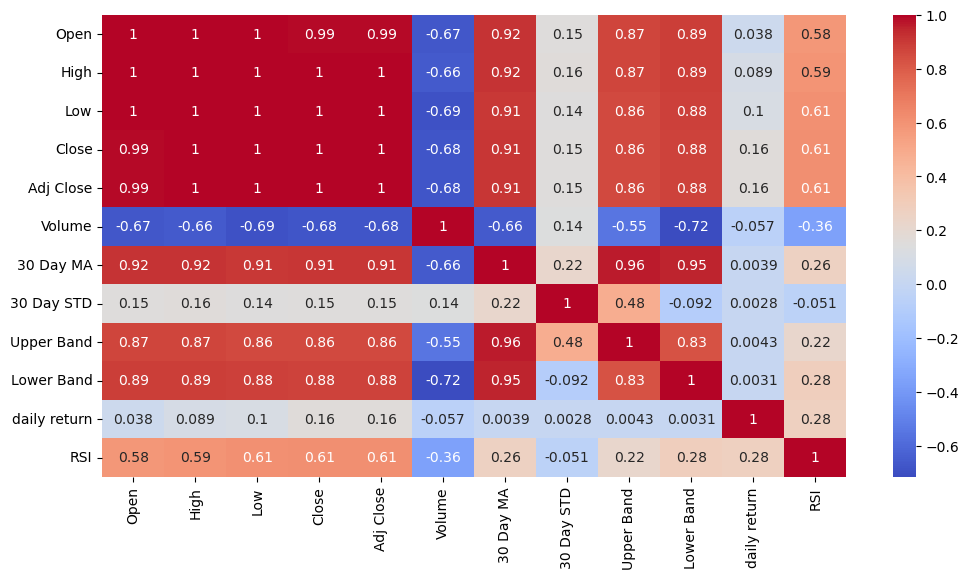

In [8]:
plt.figure(figsize=(12,6))
sns.heatmap(tsla.corr(),cmap='coolwarm',annot=True)

In [9]:
#dpecifying Dependent and Independent Variabels
X=tsla[['Open','High','Low','Close','Adj Close']]
y=tsla[['30 Day MA','30 Day STD','Upper Band','Lower Band','daily return','RSI']]
tsla.head()

,Open,High,Low,Close,Adj Close,Volume,30 Day MA,30 Day STD,Upper Band,Lower Band,daily return,RSI
Date,,,,,,,,,,,,
2022-02-14,287.190002,299.626678,284.383331,291.920013,291.920013,67756500,306.955498,16.394500,339.744497,274.166498,0.018326,45.166636
2022-02-15,300.000000,307.666656,297.793335,307.476654,307.476654,57286200,305.154164,13.966962,333.088089,277.220240,0.053291,48.402163
2022-02-16,304.683319,308.809998,300.403320,307.796661,307.796661,51294300,303.949831,12.502570,328.954970,278.944692,0.001041,63.044735
2022-02-17,304.420013,306.166656,291.366669,292.116669,292.116669,55178400,301.951164,10.853649,323.658462,280.243867,-0.050943,53.834355
2022-02-18,295.333344,295.623322,279.203339,285.660004,285.660004,68501700,300.502498,11.004363,322.511223,278.493772,-0.022103,37.548418


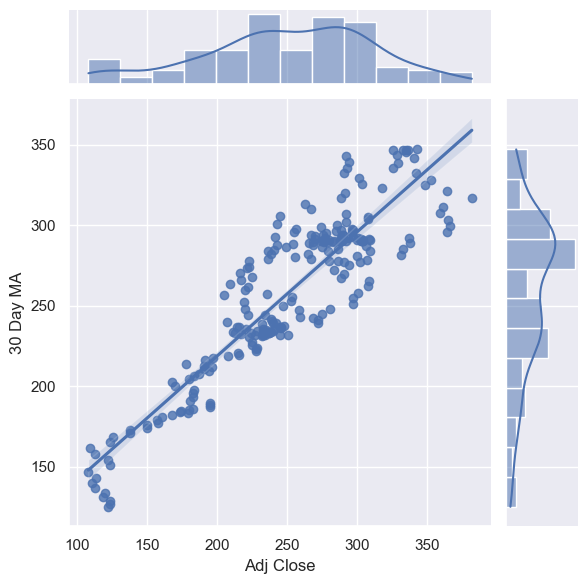

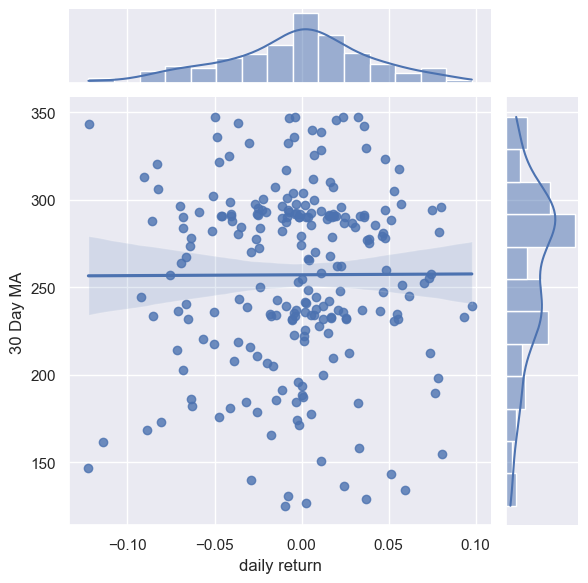

In [10]:
sns.set(color_codes=True)
sns.jointplot(x="Adj Close",y='30 Day MA',data=tsla,kind="reg")
sns.jointplot(x="daily return",y='30 Day MA',data=tsla,kind="reg")

In [20]:
y = tsla.drop('Adj Close',axis=1)
X = tsla['Adj Close'].values.reshape([-1,1])
X=pd.DataFrame(X)
print(X.shape,type(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

(231, 1) <class 'pandas.core.frame.DataFrame'>


In [22]:
rf=RandomForestRegressor()
rf.fit(X_train.values,y_train.values)
y_predict=rf.predict(X_test)

In [23]:
from sklearn import tree

In [24]:
RForest=RandomForestRegressor (random_state=5)

In [25]:
model = RForest.fit(X_train, y_train)

In [26]:
print('MAE:', mean_absolute_error(y_test, RForest.predict(X_test)))
print('MSE:', mean_squared_error(y_test, RForest.predict(X_test)))
print('RMSE:', np.sqrt(mean_squared_error(y_test, RForest.predict(X_test))))

MAE: 1822590.2842934802
MSE: 55492372039622.08
RMSE: 7449320.24010393


In [28]:
prediction=RForest.predict(X_test)
print(prediction)

[[ 3.01584924e+02  3.08111628e+02  3.00233867e+02  3.03720801e+02
   6.14679120e+07  2.90295015e+02  1.14492519e+01  3.13193519e+02
   2.67396511e+02  6.77643777e-03  5.52524212e+01]
 [ 2.80833992e+02  2.87260793e+02  2.78502306e+02  2.85020307e+02
   4.62655440e+07  2.94323373e+02  9.79860935e+00  3.13920592e+02
   2.74726155e+02  2.59708594e-03  4.66663202e+01]
 [ 2.26414904e+02  2.29503632e+02  2.15230866e+02  2.21782098e+02
   9.54963760e+07  2.55532490e+02  2.82873549e+01  3.12107200e+02
   1.98957780e+02 -1.74494320e-02  2.81151886e+01]
 [ 3.49863663e+02  3.54487665e+02  3.39340510e+02  3.46687236e+02
   7.47511380e+07  3.31484528e+02  3.21606597e+01  3.95805847e+02
   2.67163208e+02 -1.68116332e-02  6.10786988e+01]
 [ 2.76716235e+02  2.85379967e+02  2.74231696e+02  2.83508976e+02
   5.33563470e+07  2.90229293e+02  1.18456332e+01  3.13920560e+02
   2.66538027e+02  2.83266432e-02  4.01357928e+01]
 [ 2.08422866e+02  2.16734102e+02  2.05857136e+02  2.14699201e+02
   7.37658920e+07  

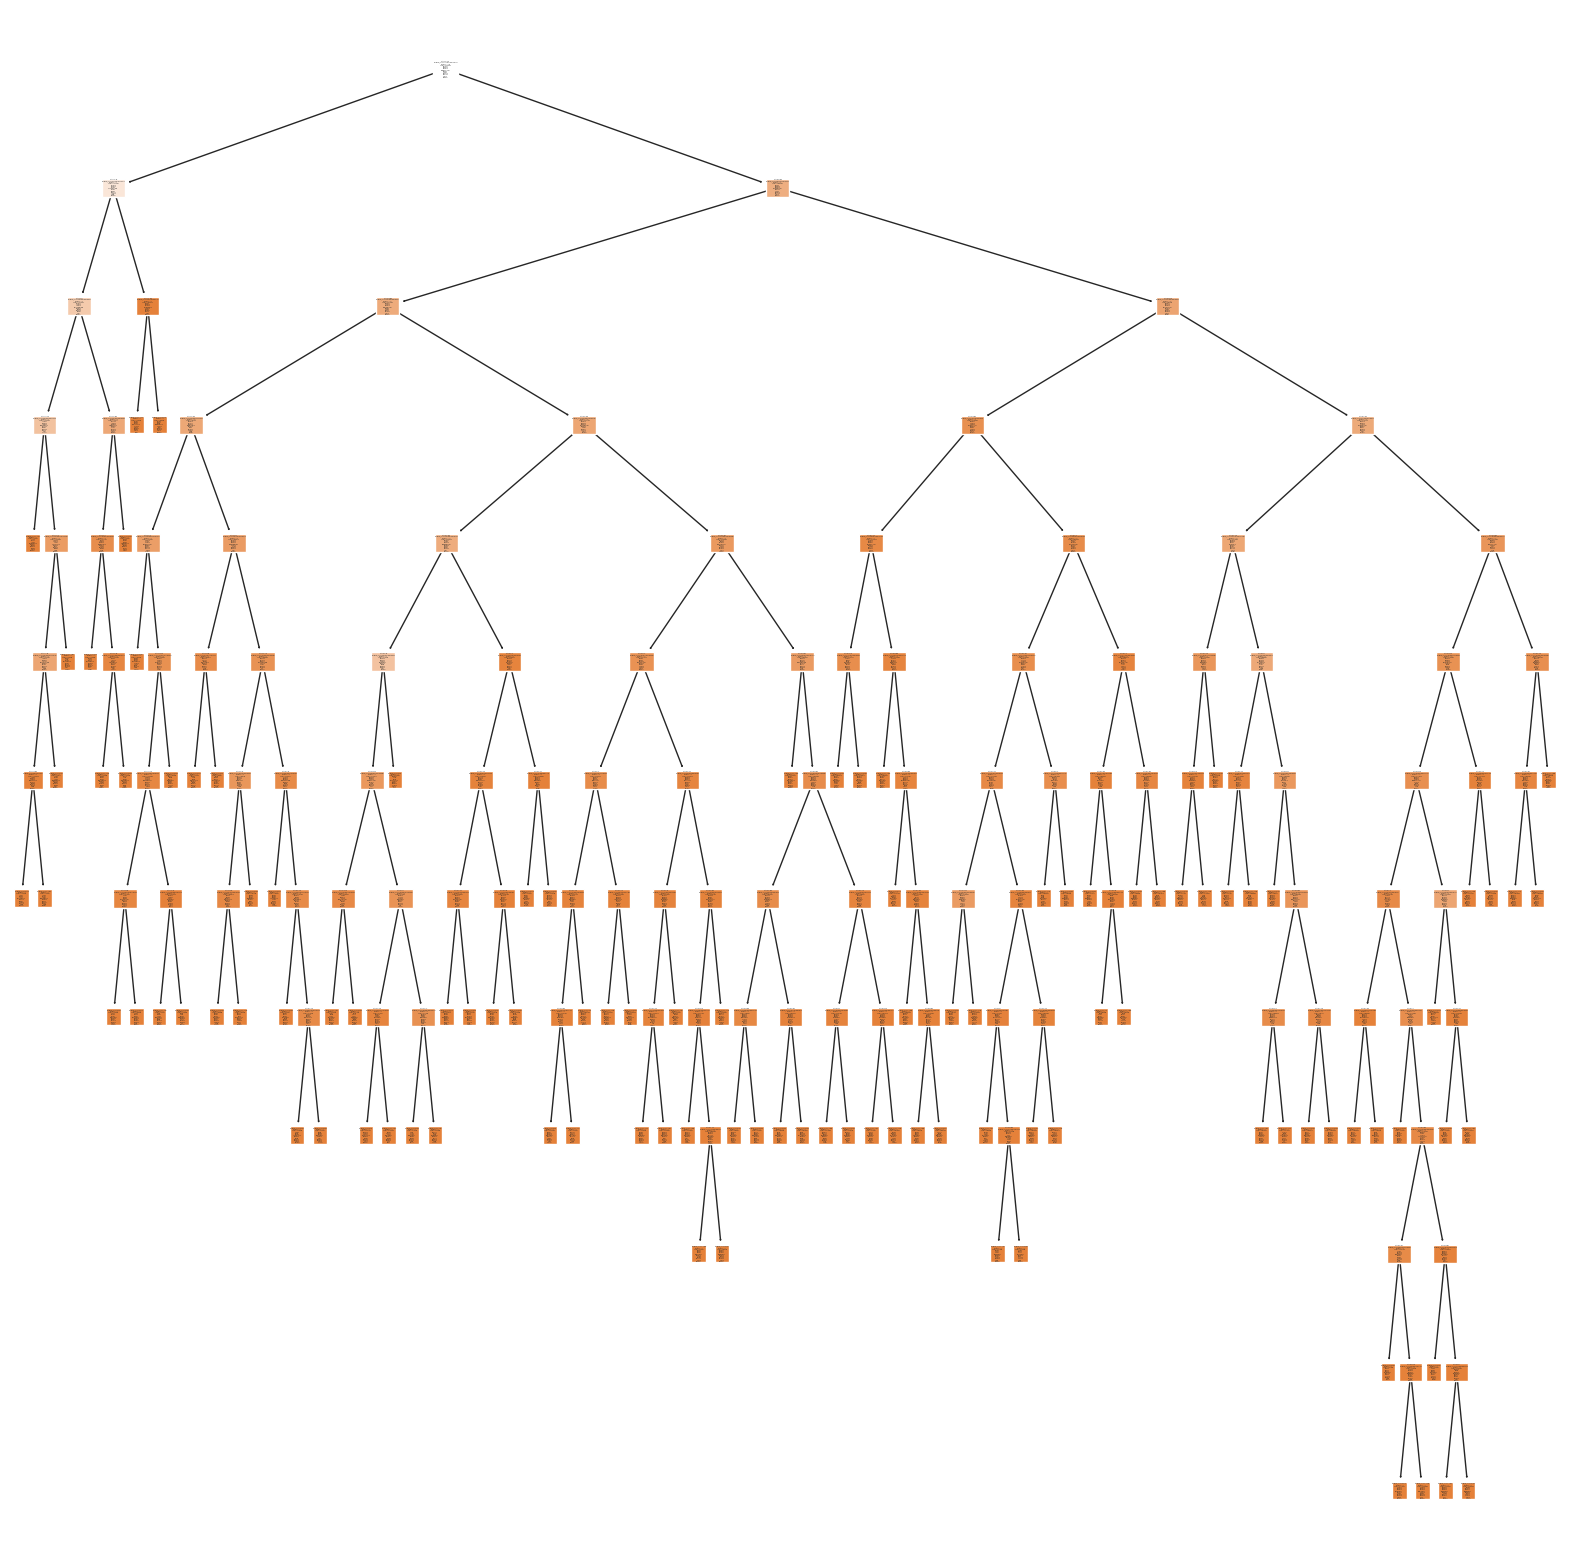

In [29]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(RForest.estimators_[0], feature_names=X.columns, filled=True)